In [5]:
import pandas as pd
from scipy import stats
import pingouin as pg
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from urllib.parse import urlencode

In [6]:
def upload_data(public_key, name_csv):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))  
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    with open(name_csv, 'wb') as f:   
        f.write(download_response.content)

In [10]:
upload_data('https://disk.yandex.ru/d/atwrlmB_wu-fHA','products.csv')
upload_data('https://disk.yandex.ru/d/prdO8FDQx7lzCg','orders.csv')
upload_data('https://disk.yandex.ru/d/4qY27tJ23G_B1g','users.csv')

In [68]:
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
users = pd.read_csv('users.csv')

In [69]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [70]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [71]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [72]:
users.groupby('group')['action'].count()

group
0    1691
1    2646
Name: action, dtype: int64

In [73]:
users.action.unique() #

array(['create_order', 'cancel_order'], dtype=object)

In [74]:
orders['product_ids'] = orders['product_ids'].str.replace('{', '').str.replace('}', '').str.split(',')

In [75]:
orders = orders.explode('product_ids')
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,75
0,1255,2022-08-26 00:00:19.000000,22
0,1255,2022-08-26 00:00:19.000000,53
0,1255,2022-08-26 00:00:19.000000,84
1,1256,2022-08-26 00:02:21.000000,56


Метрики:
- Средняя стоимость заказа
- Среднее число товаров в заказе
- Среднее число заказов на пользователя

In [76]:
orders.groupby('order_id', as_index = False).agg({'product_ids':'count'}).head()

,order_id,product_ids
0,1255,4
1,1256,3
2,1257,4
3,1258,2
4,1259,4


In [78]:
df = users.merge(orders, on='order_id')
df.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75
1,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,22
2,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,53
3,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,84
4,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,56


In [79]:
df.rename(columns={'product_ids':'product_id'}, inplace = True)

In [80]:
df['product_id'] = df['product_id'].astype('int64')

In [81]:
df = df.merge(products, how='left', on='product_id')
df.duplicated().sum()

np.int64(292)

In [82]:
df = df.drop_duplicates()
df.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,2022-08-26 00:00:19.000000,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,2022-08-26 00:02:21.000000,56,сосиски,150.0


In [85]:
df = df[['user_id', 'order_id', 'action', 'group', 'product_id','price']]
#Для удобства уберём ненужные колонки

In [86]:
df.groupby('group').action.value_counts()
#На данный момент видно, что в контрольной группе выросло число заказов, но и число отмен тоже
#С учетом примерно одинакового количества юзеров (515 и 502)

group  action      
0      create_order    5284
       cancel_order     283
1      create_order    8266
       cancel_order     444
Name: count, dtype: int64

In [87]:
df.groupby('group')['user_id'].nunique()

group
0    515
1    502
Name: user_id, dtype: int64

In [88]:
df.head()

,user_id,order_id,action,group,product_id,price
0,964,1255,create_order,0,75,120.0
1,964,1255,create_order,0,22,120.0
2,964,1255,create_order,0,53,78.3
3,964,1255,create_order,0,84,90.4
4,965,1256,create_order,1,56,150.0


In [89]:
price_test = df.groupby(['order_id','user_id','group'], as_index = False) \
.agg({'price':'sum'})

In [90]:
canceled = list(df.query("action=='cancel_order'")['order_id'])

In [91]:
price_test = price_test[~price_test['order_id'].isin(canceled)]

#Отбираем только неотменённые заказы

# Метрика 1: увеличение средней стоимости заказа после введения рекомендательной системы

Размер выборки (>30) позволяет провести t-test для сравнения средней цены заказа

Нулевая гипотеза: средняя цена заказа не изменилась в контрольной и тестовой группе

Альтернативная гипотеза: средняя цена заказа в генеральной совокупности отличается

In [92]:
a_price_test = price_test.query('group == 0 ')['price'] #Контрольная группа

In [93]:
b_price_test = price_test.query('group == 1 ')['price'] #Тестовая группа

<Axes: >

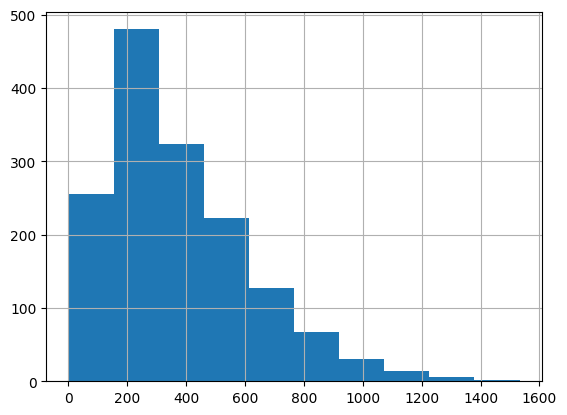

In [94]:
a_price_test.hist()

<Axes: >

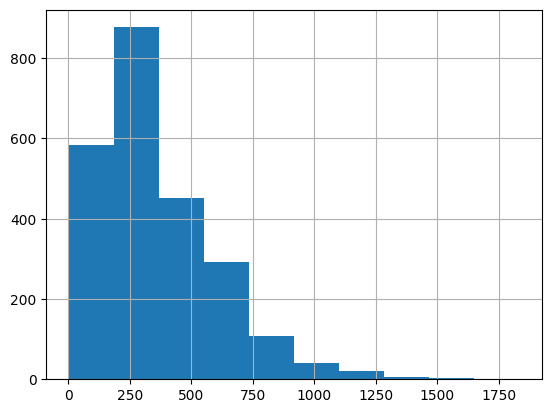

In [95]:
b_price_test.hist()

In [96]:
a_price_test.mean()

np.float64(375.0685003274394)

In [97]:
b_price_test.mean()

#Средняя цена заказа ниже в тестовой группе, осталось проверить, значимо ли это статистически

np.float64(361.49017632241817)

In [98]:
pg.homoscedasticity(price_test, dv="price", group="group")
#Проверяем однородность дисперсий

,W,pval,equal_var
levene,1.431381,0.231612,True


In [100]:
stats.ttest_ind(a_price_test, b_price_test)

TtestResult(statistic=np.float64(1.7191442255395406), pvalue=np.float64(0.08566732262411139), df=np.float64(3907.0))

p-value > 0,05 

На данный момент, мы не можем отклонить нулевую гипотезу

Средняя цена заказа статистически значимо не изменилась

# Метрика 2: увеличение среднего числа товаров  в заказе после введения рекомендательной системы

Размер выборки позволяет провести t-test для сравнения средней цены заказа

Нулевая гипотеза: среднее число товаров в заказе не изменилось в контрольной и тестовой группе

Альтернативная гипотеза: среднее число товаров в заказе отличается для тестовой и контрольных групп

In [101]:
items_test = df.groupby(['user_id', 'order_id','group'], as_index = False)['product_id'].nunique().rename(columns={'product_id':'products_count'})

In [102]:
items_test = items_test[~items_test['order_id'].isin(canceled)]

In [103]:
items_test

,user_id,order_id,group,products_count
0,964,1255,0,4
1,964,1257,0,4
2,965,1256,1,3
3,965,3946,1,4
4,965,9097,1,6
...,...,...,...,...
4118,1980,57384,1,3
4119,1980,57498,1,4
4120,1980,58430,1,6
4121,1980,58460,1,3


In [104]:
items_test = items_test.groupby(['order_id','group'], as_index = False).agg({'products_count':'sum'})
items_test

,order_id,group,products_count
0,1255,0,4
1,1256,1,3
2,1257,0,4
3,1259,1,4
4,1261,0,4
...,...,...,...
3904,59422,1,3
3905,59439,1,5
3906,59464,0,3
3907,59487,0,3


In [105]:
pg.homoscedasticity(items_test, dv="products_count", group="group")
#Проверяем однородность дисперсий

,W,pval,equal_var
levene,1.401259,0.236585,True


In [106]:
a_items_test = items_test.query("group == 0")['products_count'] #Контрольная группа

In [107]:
b_items_test = items_test.query("group == 1")['products_count'] #Тестовая группа

In [108]:
a_items_test.mean()

np.float64(3.275049115913556)

In [109]:
b_items_test.mean() #Предварительно отличий не видно

np.float64(3.283795130142737)

In [110]:
stats.ttest_ind(a_items_test, b_items_test)

TtestResult(statistic=np.float64(-0.21245978992137568), pvalue=np.float64(0.8317594280160369), df=np.float64(3907.0))

Принимаем нулевую гипотезу, введение рекомендательной системы не повлияло на среднее количество товаров в заказе

# Метрика 3: увеличение среднего числа заказов на пользователя после введения рекомендательной системы

Размер выборки позволяет провести t-test

Нулевая гипотеза: среднее число заказов(неотменённых) на юзера не изменилось в контрольной и тестовой группе

Альтернативная гипотеза: среднее число заказов на юзера отличается для тестовой и контрольных групп

In [111]:
users_test = df[~df['order_id'].isin(canceled)] #Убираем отменённые заказы

In [112]:
users_test = users_test.groupby(['user_id','group'], as_index = False)['order_id'] \
.nunique() \
.rename(columns={'order_id':'orders_count'})

In [113]:
a_users_test = users_test.query('group == 0')['orders_count'] #Контрольная группа

In [114]:
b_users_test = users_test.query('group == 1')['orders_count'] #Тестовая группа

In [115]:
a_users_test.mean()

np.float64(2.982421875)

<Axes: >

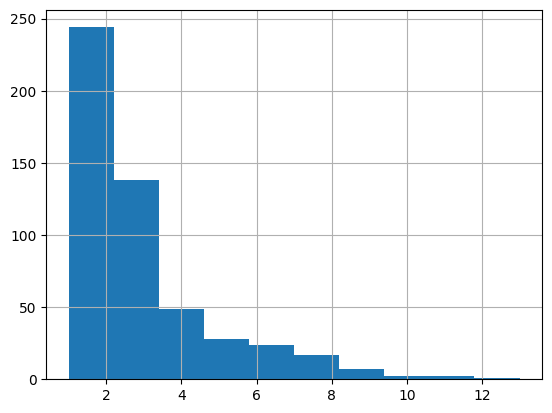

In [116]:
a_users_test.hist()

In [117]:
b_users_test.mean() 

np.float64(4.754491017964072)

<Axes: >

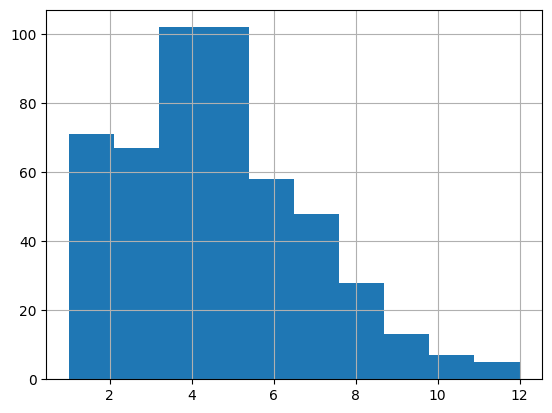

In [118]:
b_users_test.hist()

In [119]:
pg.homoscedasticity(users_test, dv="orders_count", group="group")
#Проверяем однородность дисперсий, дисперсии неоднородны, используем t-критерий Уэлча

,W,pval,equal_var
levene,17.195942,0.000037,False


In [120]:
pg.ttest(a_users_test, b_users_test, paired=False, alternative='two-sided', correction='auto', r=0.707, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-13.97417,989.822835,two-sided,1.237410e-40,"[-2.02, -1.52]",0.879358,1.801e+37,1.0


t-test с p-value сильно меньше 0,05 позволяет нам отклонить нулевую гипотезу

Введение рекомендательной системы значимо повлияло на увеличение среднего числа заказов на юзера

# Итоговый вывод:

Введение рекомендательной системы статистически значимо не повлияло на изменение средней стоимости заказа и среднего числа товаров в заказе

Тем не менее, наблюдается статистически значимое увеличение количества заказов на пользователя

По результатам анализа, можно сделать вывод, что рекомендательную систему стоит включать для всех пользователей